# Plots of the double density 

## Bare plots

We plot the coefficients $O_n$, $c_n$ and $s_n$ of the double density.

In [1]:
#Loading the libraries
from pytriqs.archive import *
%matplotlib inline
from pylab import *
import matplotlib.pyplot  as plt
import numpy as np

In [3]:
#Loading the coefficients in the HDF5 file
cn_values_list,cn_errors_list=[],[]
on_values_list,on_errors_list=[],[]
sn_values_list,sn_errors_list=[],[]

RS1_seed = 249645
RS2_seed = 157897

#The path to the files
name = 'results_nmax14/' +'results_nmax14.h5'
#My values, with the error bars
R = HDFArchive(name, 'r')  # Opens in readonly mode
cn_values = R['cn_values']
on_values = R['on_values']
sn_values = R['sn_values']
#Relative errors
cn_errors_rel = R['cn_errors']
on_errors_rel = R['on_errors']
sn_errors_rel = R['sn_errors']

#Absolute errors
cn_errors=np.multiply(cn_values,cn_errors_rel)
on_errors=np.multiply(on_values,on_errors_rel)
sn_errors=np.multiply(sn_values,sn_errors_rel)


Nmax = len(on_values) - 1;
print Nmax #(up to order Nmax included)

14


In [4]:
# Parameters
alpha = 0.0
gamma = 0.5
epsilon_d = 0.
tmax = 10.
muL = 0.
muR = 0.
beta = 200.
U_qmc = 2.
n_cycles = 20000
n_warmup_cycles = 10000
length_cycle = 10

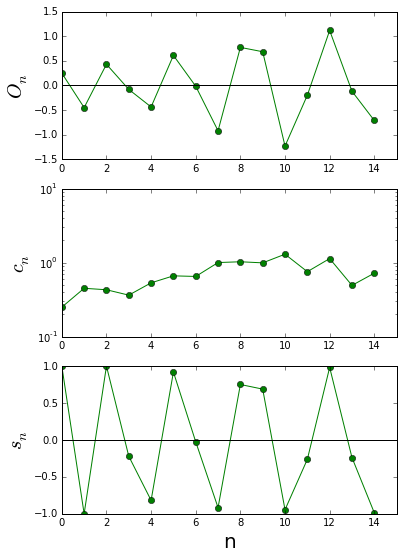

In [5]:
fig, (ax1,ax2,ax3)= plt.subplots(nrows=3, ncols=1, figsize=(6,9))
ax1.errorbar(array(range(Nmax+1)),on_values,yerr=on_errors,fmt='-og')
ax1.plot([0,15],[0,0],color='black')
#ax1.legend(['O'])
ax1.set_ylabel('$O_n$',fontsize=20)
ax1.set_ylim(-1.5,1.5)
ax1.set_xlim(0,15)
ax2.errorbar(array(range(Nmax+1)),cn_values,yerr=cn_errors,fmt='-og')
ax2.set_ylabel('$c_n$',fontsize=20)
ax2.set_yscale('log')
ax2.set_xlim(0,15)
ax3.errorbar(array(range(Nmax+1)),sn_values,yerr=sn_errors,fmt='-og')
ax3.plot([0,15],[0,0],color='black')
ax3.set_xlabel('n',fontsize=20)
ax3.set_ylabel('$s_n$',fontsize=20)
ax3.set_xlim(0,15)
plt.savefig('double_densite.pdf')

## Summation of the series

We plot the partial series for various $N_{max}$

In [7]:
#Defining a grid in U
U_min = 0.
U_max = 1.
U_mesh_size = 1000
O_values_5=[]
O_values_7=[]
O_values_9=[]
O_values_11=[]
O_values_13=[]
O_values_14=[]
U_values=[]

for i_U in range(U_mesh_size+1):
    O_temp = 0
    for j_sum in range(Nmax+1):
        O_temp += on_values[j_sum] * (U_min + (U_max-U_min)*i_U/U_mesh_size) ** (j_sum)
        if(j_sum == 5):
            O_values_5.append(O_temp)
        if(j_sum == 7):
            O_values_7.append(O_temp)
        if(j_sum == 9):
            O_values_9.append(O_temp)
        if(j_sum == 11):
            O_values_11.append(O_temp)
        if(j_sum == 13):
            O_values_13.append(O_temp)
        if(j_sum == 14):
            O_values_14.append(O_temp)
    U_values.append(U_min + (U_max-U_min)*i_U/U_mesh_size)

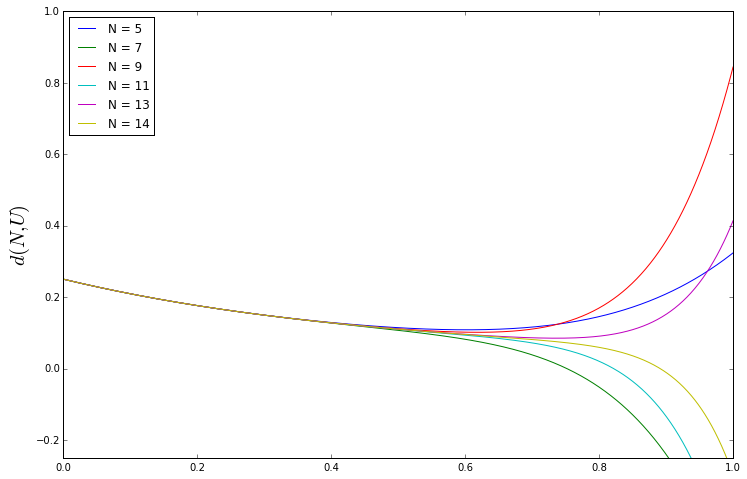

In [8]:
fig, ax1= plt.subplots(nrows=1, ncols=1, figsize=(12,8))
ax1.plot(U_values,O_values_5)
ax1.plot(U_values,O_values_7)
ax1.plot(U_values,O_values_9)
ax1.plot(U_values,O_values_11)
ax1.plot(U_values,O_values_13)
ax1.plot(U_values,O_values_14)
ax1.set_ylabel('$d(N,U)$',fontsize=20)
ax1.legend(['N = 5','N = 7','N = 9','N = 11','N = 13','N = 14'],loc=0)
ax1.set_ylim(-0.25,1)
ax1.set_xlim(U_min,U_max)
plt.savefig("d_variousN.pdf")

## Moving away the singularity

We do a homographic transform of $U$, with parameters $a$ and $b$ : 

$$W(U) = \frac{b U}{U-a}$$

Since we have $$U = - \frac{a W}{b-W} = -a \sum\limits_{p = 1}^{\infty} \frac{W^p}{b^p}$$ for $W < b$

We thus find for $W < b$ : 

$$\bar{Q}_N(W) = Q_N(U(W)) = \sum\limits_{p=1}^{\infty} \bar{Q}_p W^p$$

Here we will take (following the paper) $b = 6$ and $a$ between $-1$ and $0$.


### Computation of the figure of merit

We want to find the optimal value of $a$. So we fix a value of $U$, let us say $U = 6$ as in the paper and we will compute $R_W(a)$ simply by fitting $\bar{Q}_p(a)$ to $R_W^{-p}$. Then we will compare $R_W(a)$ to $W(a,U=U_f=6)$ and we will take the $a$ such that this quantity is maximal. 


Then we will plot for this value of $a$, let's say $a_{opt}$, the value of the coefficients $\bar{Q}_p$ with $p$ to see that they converge fastly to 0 as compared to the original ones.

In [10]:
#new one, using the fonctions of Xavier and the R matrix, way faster
from series_xavier import Rmatrix
from series_xavier import ConvRadius
from numpy.polynomial import Polynomial as Poly
b = 6. 
a_min=-1.
a_max=0.
a_mesh_size=1000
U_fixed = 2.

a_values=[]
RW_values=[]
W_values=[]

pmax = Nmax #Maximal value of the p for W
Q_pol = Poly(on_values)

#We will need it for the R matrix
on_values_without0 = np.delete(on_values,0)

for i_a in range(a_mesh_size): #We avoid the a=0 case
    if(i_a * 10 % a_mesh_size == 0):
        print i_a
        
    a_values.append(a_min + (a_max-a_min)*i_a/a_mesh_size)
    W_values.append(b*U_fixed/(U_fixed-a_values[-1]))
    
    #The R matrix
    W_array=[]#W as a serie of U
    #W_array.append(0) #First coeff is 0, but this is already assumed in Rmatrix
    for i_W in range(1,pmax+1):
        W_array.append(-b*(1/a_values[-1])**i_W)
    R_matrix_W = Rmatrix(W_array)
    inv_R = np.linalg.inv(R_matrix_W)
    Q_bar = np.dot(inv_R,on_values_without0) #Qbar without the n=0 value
    
    #We add the n=0 value
    Q_bar = np.concatenate(([on_values[0]],Q_bar))
    
    Q_bar_poly = Poly(Q_bar)
    RW_values.append(ConvRadius(Q_bar_poly))

0
100
200
300
400
500
600
700
800
900


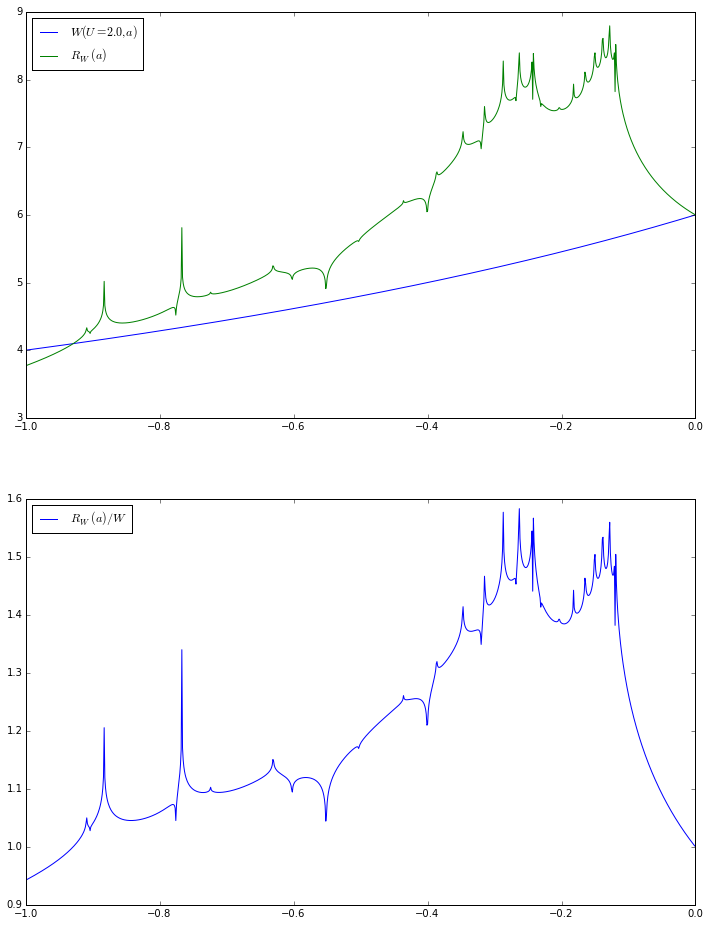

In [13]:
fig, (ax1,ax2)= plt.subplots(nrows=2, ncols=1, figsize=(12,16))
ax1.plot(a_values,W_values)
ax1.plot(a_values,RW_values)
ax1.legend(['$W(U={0},a)$'.format(U_fixed),'$R_W(a)$'],loc=0)
ax1.set_xlim(a_min,a_max)
ax2.plot(a_values,[RW_values[i]/W_values[i] for i in range(a_mesh_size)])
ax2.legend(['$R_W(a)/W$'],loc=0)
ax2.set_xlim(a_min,a_max)
plt.savefig("figure_merite_U_{0}.pdf".format(U_fixed))

In [15]:
#Finding the maximum merit ratio
import operator
max_index, max_value = max(enumerate([RW_values[i]/W_values[i] for i in range(a_mesh_size)]), key=operator.itemgetter(1))
RW_opt = RW_values[max_index]
a_opt = a_values[max_index]
print(max_value)
print(RW_opt)
print(a_opt)

1.58334140031
8.39597737682
-0.263


In [16]:
#Get the values of the resummed coefficients for a = o_opt
Q_pol = Poly(on_values)

#The R matrix
W_array=[]#W as a serie of U
for i_W in range(1,pmax+1):
    W_array.append(-b*(1/a_opt)**i_W)
R_matrix_W_opt = Rmatrix(W_array)
inv_R_opt = np.linalg.inv(R_matrix_W_opt)
Q_bar_opt = np.dot(inv_R_opt,on_values_without0)#Without the p = 0 value

#We add the p=0 value, it is the same for Qbar and Q since U = 0 <-> W = 0
Q_bar_opt = np.concatenate(([on_values[0]],Q_bar_opt))
Q_bar_pol_opt = Poly(Q_bar_opt)

## Computation of the errors on the resummed series

The principle is simple : 

$$\sum_{p=0}^N \bar{Q}_p W(U)^p = \sum_{p=0}^N R(\bar{Q})_p U^p$$ with $R$ a matrix given by Xavier's script, depending only on $W(U)$. 
So one has 

$$\bar{Q}_p = R(W)^{-1}Q $$ so 

$$\Delta \bar{Q}_p = \sqrt{\sum_{k=1}^N |R(W)^{-1}_{p,k}|^2 \Delta Q_{k}^2}$$

So one just has to multiply the original errors by a matrix that we already have !

In [17]:
#Computation of the errors on the new coefficients
on_bar_errors=np.zeros(Nmax+1)
for p in range(1,Nmax+1):
    temp = 0
    for k in range(1,Nmax+1):
        temp += (inv_R_opt[p-1,k-1])**2 * on_errors[k] ** 2
    on_bar_errors[p] = np.sqrt(temp)

## Comparison between the old series and the new one

In [19]:
Q_old = on_values #Old series
Q_bar_opt = Q_bar_pol_opt.coef #New series

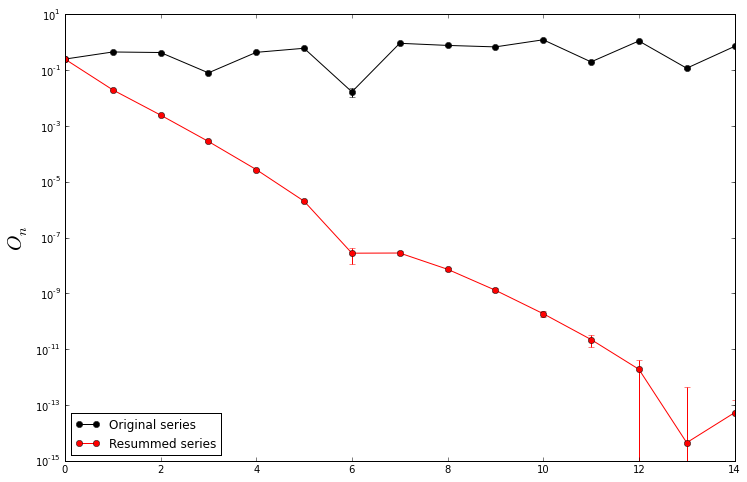

In [20]:
fig, ax1= plt.subplots(nrows=1, ncols=1, figsize=(12,8))
ax1.errorbar(array(range(Nmax+1)),np.abs(Q_old),yerr=on_errors,fmt='-og',color='black')
ax1.errorbar(array(range(Nmax+1)),np.abs(Q_bar_opt),yerr=on_bar_errors,fmt='-og',color='red')
ax1.set_ylabel('$O_n$',fontsize=20)
ax1.set_yscale('log')
ax1.legend(['Original series','Resummed series'],loc=0)
#ax1.set_ylim(-0.25,1)
plt.savefig("resummed_series.pdf")

## Comparison of the original and the resummed function of U

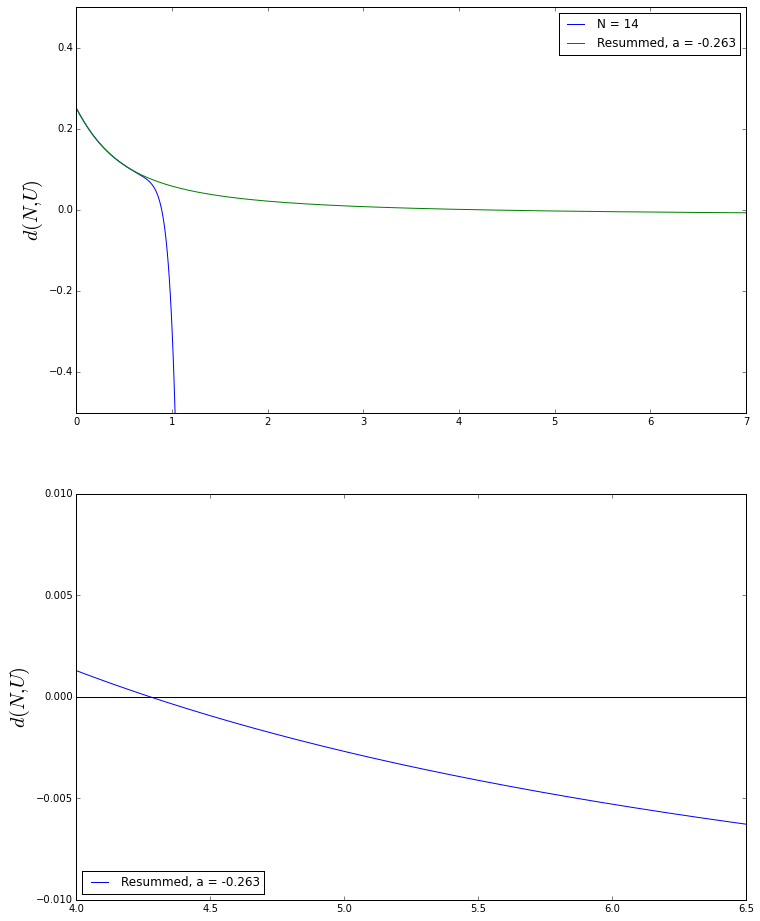

In [22]:
#Defining a grid in U
U_min = 0.
U_max = 10.
U_mesh_size = 1000
O_values=[]
O_values_resummed=[]
U_values=[]

#Calculating the values
for i_U in range(U_mesh_size+1):
    O_temp = 0
    for j_sum in range(Nmax+1):
        O_temp += on_values[j_sum] * (U_min + (U_max-U_min)*i_U/U_mesh_size) ** (j_sum)
        if(j_sum == Nmax):
            O_values.append(O_temp)
    U_values.append(U_min + (U_max-U_min)*i_U/U_mesh_size)
    O_values_resummed.append(Q_bar_pol_opt(b*U_values[-1]/(U_values[-1]-a_opt)))
    
#Plotting the results
fig, (ax1,ax2)= plt.subplots(nrows=2, ncols=1, figsize=(12,16))
ax1.plot(U_values,O_values)
ax1.plot(U_values,O_values_resummed)
ax1.set_ylabel('$d(N,U)$',fontsize=20)
ax1.legend(['N = {0}'.format(Nmax),'Resummed, a = {0}'.format(a_opt)],loc=0)
ax1.set_xlim(0,7)
ax1.set_ylim(-0.5,0.5)
ax2.plot(U_values,O_values_resummed)
ax2.plot([0,8],[0,0],c='black')
ax2.set_ylabel('$d(N,U)$',fontsize=20)
ax2.legend(['Resummed, a = {0}'.format(a_opt)],loc=0)
ax2.set_xlim(4,6.5)
ax2.set_ylim(-0.01,0.01)
plt.savefig("resummed_serie_U.pdf")

# Comparison with the cthyb values

We compare our values with the cthyb values, obtained for the same values of n_cycles, length_cycle and n_warmup_cycles.

More precisely, we plot the resummed values of the double density compared to the ones obtained by cthyb, for various U

In [23]:
R_cthyb = HDFArchive('results_comparison_ctint_cthyb/results_cthyb_comparison_ctint.h5', 'r')  # Opens in readonly mode
U_values_cthyb = R_cthyb['U']
nn_values_cthyb = R_cthyb['nn']

In [24]:
#Defining a grid in U
U_min = 0.
U_max = 4.
U_mesh_size = 1000
O_values_resummed=[]
U_values=[]

for i_U in range(U_mesh_size+1):
    U_values.append(U_min + (U_max-U_min)*i_U/U_mesh_size)
    O_values_resummed.append(Q_bar_pol_opt(b*U_values[-1]/(U_values[-1]-a_opt)))

In [25]:
nb_points_error=100 #We do not compute the error for every value, to have something readable
O_values_for_error=[]
U_values_for_error=[]
O_error_values=[]
for i in range(nb_points_error):
    U_values_for_error.append(U_min + (U_max-U_min)*i/nb_points_error)
    O_values_for_error.append(Q_bar_pol_opt(b*U_values_for_error[-1]/(U_values_for_error[-1]-a_opt)))
    
    #Computing the error in the resummed series, by propagation of uncertainty
    error_temp=0
    W_value = b*U_values_for_error[-1]/(a_opt-U_values_for_error[-1])
    for j in range(Nmax+1):
        error_temp += (abs(W_value))**(2*j) * abs(on_bar_errors[j])**2
    O_error_values.append(np.sqrt(error_temp))

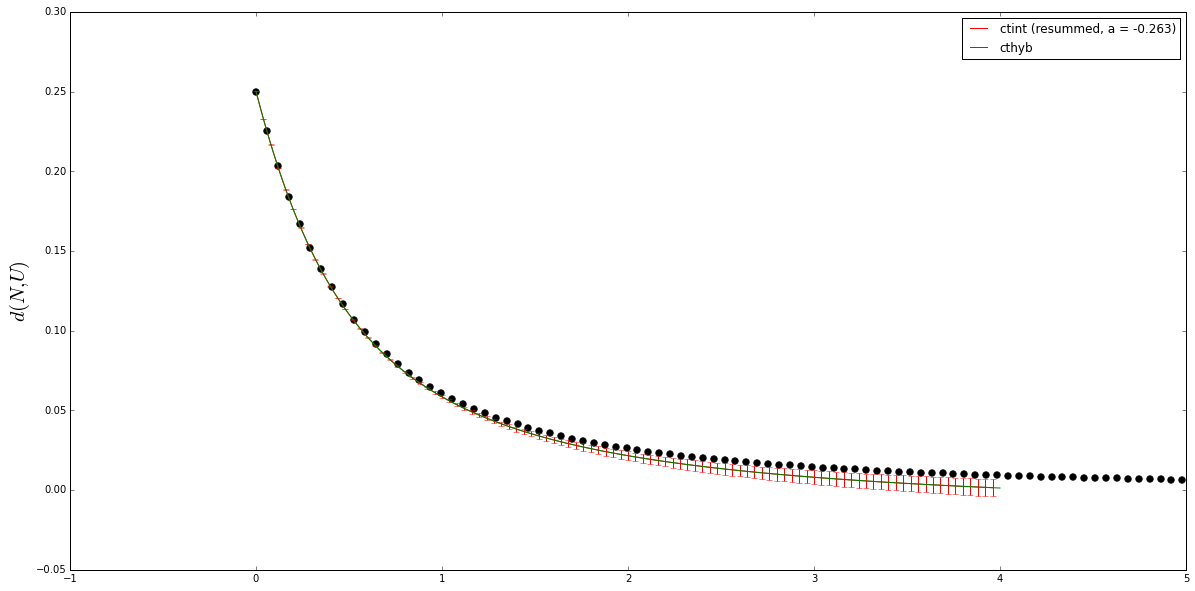

In [27]:
fig, ax1= plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax1.errorbar(U_values_for_error,O_values_for_error,yerr=O_error_values,c='red',fmt='-')
ax1.plot(U_values,O_values_resummed,c='green')
ax1.scatter(U_values_cthyb,nn_values_cthyb,c='black',zorder=2,s=40)
ax1.set_ylabel('$d(N,U)$',fontsize=20)
ax1.legend(['ctint (resummed, a = {0})'.format(a_opt),'cthyb'],loc=0)
ax1.set_xlim(-1,5)
plt.savefig('ctint_cthyb_U_{0}.pdf'.format(U_fixed))

## Fit des resultats exacts

On fit les resultats exacts de cthyb sur $e^{-a U}$. On calcule a. 

Question : on a besoin de combien d'ordres pour U = 5 par exemple pour avoir la valeurs ?

(0.1, 50)

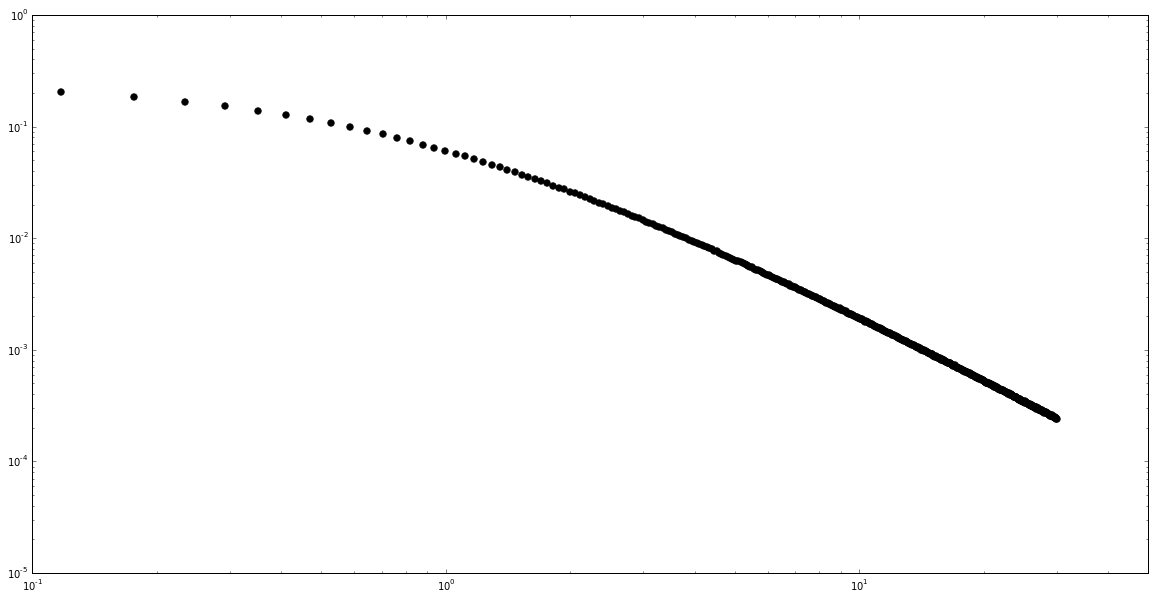

In [28]:
fig, ax1= plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax1.scatter(U_values_cthyb,nn_values_cthyb,c='black',zorder=2,s=40)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim(1.0e-5,1)
ax1.set_xlim(1.0e-1,50)

In [30]:
#Fitting as a power-law
from scipy.optimize import curve_fit
def func(x, a, b):
    return a -b * x

In [31]:
#Deleting the firts values of U for which the power-law behavior is bad
U_first=6.
U_new = U_values_cthyb
nn_new = nn_values_cthyb

U_without0 = np.delete(U_new,0)
nn_without0 = np.delete(nn_new,0)

for j in range(len(U_new)):
    if U_new[0] < U_first :
        U_new=np.delete(U_new,0)
        nn_new=np.delete(nn_new,0)

In [32]:
#Fitting
popt, pcov = curve_fit(func, np.log(U_new), np.log(nn_new))

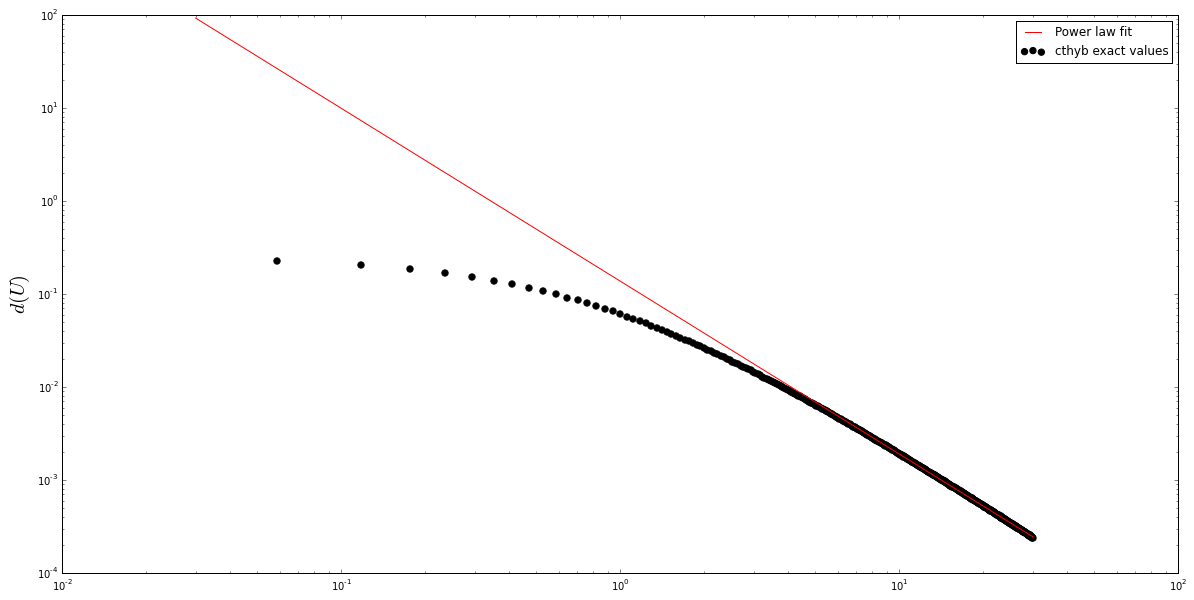

In [33]:
#Comparing to the original data
Umin_fit = 0.
Umax_fit  = 30.0
U_mesh_size_fit=1000
U_fit=[]
O_fit=[]
for i_U in range(1,U_mesh_size_fit+1):
    U_fit.append(Umin_fit + (Umax_fit-Umin_fit)*i_U/U_mesh_size_fit)
    O_fit.append((np.exp(popt[0]))*(U_fit[-1])**(-popt[1]))

fig, ax1= plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax1.scatter(U_without0,nn_without0,c='black',zorder=2,s=40)
ax1.plot(U_fit,O_fit,c='red')
ax1.set_ylabel('$d(U)$',fontsize=20)
ax1.legend(['Power law fit','cthyb exact values'],loc=0)
ax1.set_yscale('log')
ax1.set_xscale('log')

# Old tries, not working after this point

In [25]:
U_value=5
b_opt=popt[1]
value = np.exp(-U_value*b_opt)
liste_values_orders=[]
N_max = 50
for i in range(N_max+1):
    if i ==0:
         liste_values_orders.append(1-value) #So that we compare the series to 0
    else:
        liste_values_orders.append(liste_values_orders[i-1] + (-b_opt *U_value)**i/np.math.factorial(i) )

liste_values_orders/= value

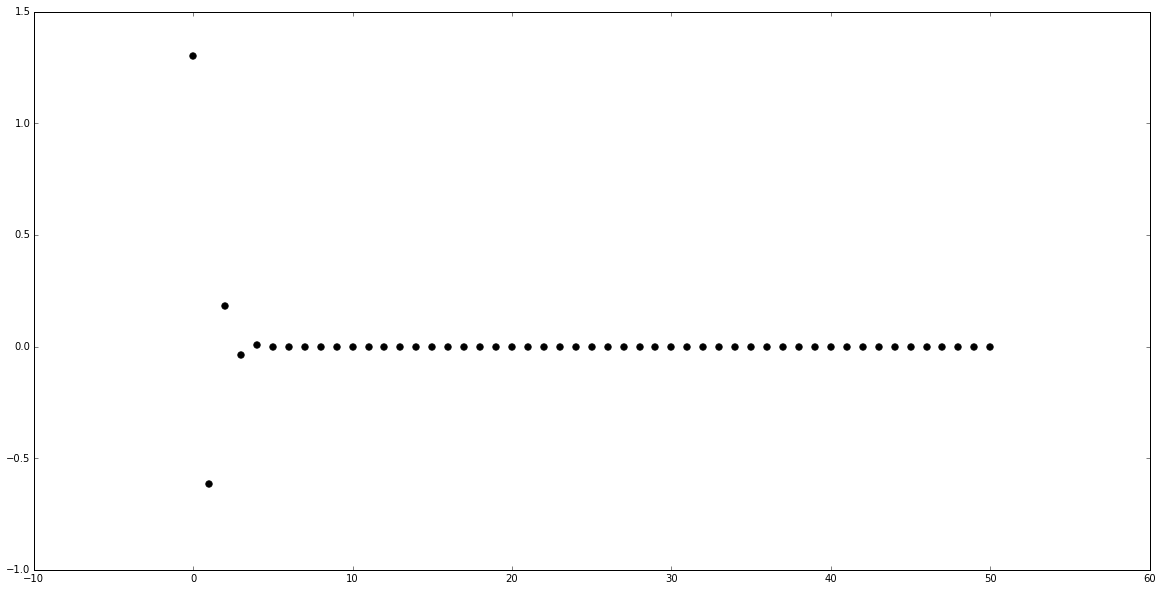

In [26]:
fig, ax1= plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax1.scatter(range(N_max+1),liste_values_orders,c='black',zorder=2,s=40)

In [40]:
liste_values_orders

array([  1.30236332e+00,  -6.17660631e-01,   1.82928040e-01,
        -3.96185652e-02,   6.77884840e-03,  -9.59647487e-04,
         1.15921062e-04,  -1.22154336e-05,   1.14177302e-06,
        -9.58999978e-08,   7.31402679e-09,  -5.10873577e-10,
         3.29153490e-11,  -1.96813032e-12,   1.09769231e-13,
        -5.75313536e-15,   2.68006838e-16,  -2.73606923e-17,
        -1.36763781e-17,  -1.42770015e-17,  -1.42519574e-17,
        -1.42529519e-17,  -1.42529142e-17,  -1.42529156e-17,
        -1.42529156e-17,  -1.42529156e-17,  -1.42529156e-17,
        -1.42529156e-17,  -1.42529156e-17,  -1.42529156e-17,
        -1.42529156e-17,  -1.42529156e-17,  -1.42529156e-17,
        -1.42529156e-17,  -1.42529156e-17,  -1.42529156e-17,
        -1.42529156e-17,  -1.42529156e-17,  -1.42529156e-17,
        -1.42529156e-17,  -1.42529156e-17,  -1.42529156e-17,
        -1.42529156e-17,  -1.42529156e-17,  -1.42529156e-17,
        -1.42529156e-17,  -1.42529156e-17,  -1.42529156e-17,
        -1.42529156e-17,

# Resommation controlee

On va utiliser une astuce : on peut fiter les valeurs de cthyb sur une exponentielle (prendre plus de valeurs a U grand), ca nous donne un a et un b pour dire que 

$$\bar{O}_n \sim a \frac{(-b)^n}{n!}$$ 

Ensuite on va calculer $\bar{O}_n - a \frac{(-b)^n}{n!}$ et resommer cette serie la.

In [35]:
Q_new=[]
for i in range(Nmax+1):
    #Q_new.append(Q_bar_opt[i] - np.exp(popt[0])*(-popt[1])**i/(np.math.factorial(i)))
    Q_new.append(Q_bar_opt[i] - (-1.25)**i/(np.math.factorial(i)))

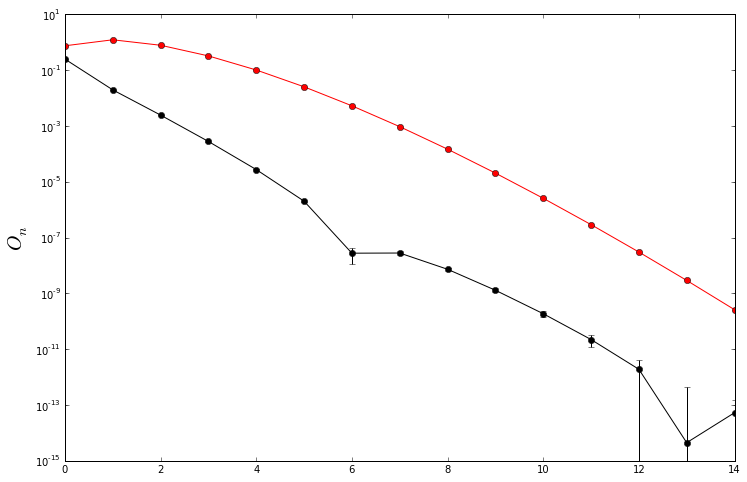

In [36]:
fig, ax1= plt.subplots(nrows=1, ncols=1, figsize=(12,8))
ax1.errorbar(array(range(Nmax+1)),np.abs(Q_bar_opt),yerr=on_bar_errors,fmt='-og',color='black')
ax1.errorbar(array(range(Nmax+1)),np.abs(Q_new),yerr=on_bar_errors,fmt='-og',color='red')
ax1.set_ylabel('$O_n$',fontsize=20)
ax1.set_yscale('log')

In [34]:
popt

array([-4.05165562,  0.16678723])